In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_08 import *

# Get imagenette data

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [3]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

# Get model

In [4]:
nfs = [32,64,128,256]

cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [5]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [6]:
run.fit(1, learn)

train: [1.7591397282650845, tensor(0.3941, device='cuda:0')]
valid: [1.4555020751953125, tensor(0.4880, device='cuda:0')]


# One optimizer to rule them all

## Rewrite pytorch optimizer

In PyTorch, the **base optimizer in torch.optim is just a dictionary** that stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups (different groups can have different learning rates/momentum/weight decay... which is what lets us do discriminative learning rates).

It **contains a method step that will update our parameters** with the gradients and a method **zero_grad to detach and zero the gradients of all our parameters**.



```python
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x
```

In [50]:
class Optimizer():
    # might be a generator
    def __init__(self, params, steppers, **defaults):
        # - params: a list of list, e.g. params= model.parameters() -> [[<layer1_params>,<layer2_params>,...]] #1 group
        #     outer lists are for groups, inner lists are for layers in that group (params)
        # - defaults: default value of hyperparams, e.g. {'lr': 0.1}
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
            
        self.hypers = [{**defaults} for p in self.param_groups] # e.g. [{'lr':0.1},{'lr':0.1}] for 2 groups
        # this will clone dict so each param groups can have different/unrelated dict
        
        self.steppers = listify(steppers)

    def grad_params(self):
        # actual weight params needed to be updated using optimizers
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]
        # [( <group1_layer1_params>,{'lr':0.1} ),...,( <group2_layer1_params>,{'lr':0.1} ),...]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_() #remove gradient computation history
            p.grad.zero_()

    def step(self):
        # apply list of stepper funcs on each layer params (weights) with hyperparams (e.g. lr) as func inputs
        # hyper is passed as kwargs in compose func (see cell above)
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)
        
        # e.g., if steppers is sgd_step, compose function will update p (weight) using p.grad and lr in **hyper
        # ignore output of compose

## SGD

In [55]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data) # p.data= p.data - lr* p.grad.data
    return p

In [56]:
opt_func = partial(Optimizer, steppers=[sgd_step])

## rewrite some callbacks

```python
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[] 

    def after_batch(self): # save learning rate (of only last groups) and loss after training each batch
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr']) # get lr of last groups and append to lrs
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

```

In [61]:
# this only record last group param
class Recorder(Callback):
    def begin_fit(self):         
        self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

```python
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs): # different sched func for each group
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()
```

In [62]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): # put set_param in begin_batch
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
            
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): 
            h[self.pname] = f(pos)
   

In [63]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [64]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [65]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [76]:
 #where our custom opt_func is used to initialize Optimizer
??get_runner

In [66]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

# Check optimizer attributes

In [23]:
learn.opt

In [43]:
len(learn.opt.param_groups)

1

In [45]:
type(learn.opt.param_groups[0]),type(learn.opt.param_groups[0][0]),learn.opt.param_groups[0][0].shape

(list, torch.nn.parameter.Parameter, torch.Size([16, 3, 3, 3]))

In [46]:
learn.opt.hypers

[{'lr': 0.4}]

In [49]:
learn.opt.grad_params() # empty for now since no grad has been calculated. Will be populated once model runs batches

[]

In [67]:
%time run.fit(1, learn)

train: [1.7599143739336125, tensor(0.3919, device='cuda:0')]
valid: [1.385638427734375, tensor(0.5300, device='cuda:0')]
CPU times: user 3.25 s, sys: 1.38 s, total: 4.63 s
Wall time: 5.18 s


In [71]:
type(learn.opt.grad_params()[0][0]), learn.opt.grad_params()[0][1]

(torch.nn.parameter.Parameter, {'lr': 0.20019741842537647})

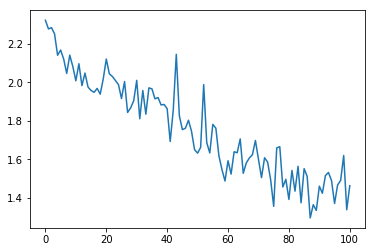

In [77]:

run.recorder.plot_loss()

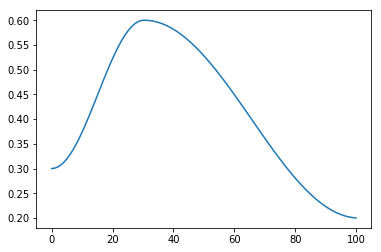

In [78]:

run.recorder.plot_lr()